In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt

import pickle as pkl

from sklearn.model_selection import train_test_split

import keras.metrics
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [2]:
spacy_nlp = spacy.load('en_core_web_sm')

In [3]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove_data/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [5]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")
result_umap_types  = pd.read_csv("data/output_csv/result_umap_types.csv")

In [6]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [7]:
result_umap_types.head()

,Unnamed: 0,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,0,infj,11.12,135.2900,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.910143,7.477874
1,1,entp,23.40,187.4756,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.938040,5.939636
2,2,intp,16.72,180.6900,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.740153,5.486389
3,3,intj,21.28,181.8324,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.415134,7.452929
4,4,entj,19.34,196.4576,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2.083198,7.512875


In [8]:
labels = ["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp", "infj", "infp", "intj", "intp", "isfj", 
          "isfp", "istj", "istp"]
y = result_umap_types[labels].values
X = mbti_df_clean["posts_clean"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940,) (6940, 16) (1735,) (1735, 16)


In [10]:
X_train = list(X_train)

In [11]:
texts = [line for line in X_train] 

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [13]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 90265


In [14]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6940, 200)
Shape of label tensor: (6940, 16)


In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y_train[indices]

In [16]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print ((x_train.shape),(y_train.shape),(x_val.shape),(y_val.shape))

(5552, 200) (5552, 16) (1388, 200) (1388, 16)


In [17]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [ 125  450  152  438   31   33   28   59  922 1171  725  800   98  177
  129  214]
validation:  [ 24 100  35 112   4   7   4  15 260 291 173 211  23  41  32  56]


In [18]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 1063   135  2289  1284   315   490  1810   199  8035   661  9264  3640
   232  1266 22385    17   898  3405    24    66 39762   375  1583   154
 55407    61 39763 55408     6     1  2872    79   162 12842  4886  3339
  4886  4886  8426     1   996   583   232 25677    18  2321    43   232
   384 14337 14277   198 12662 16953  6957    43 39434 10721   147 39764
 55409   151 55410  9093   198 32961   196   232  1127  3707    17  8023
 14606   147    65  8426  3308 25676     2 16853  7582  4105    75    21
   312   152   630    21   452   113     4   957  1297  1088    83  4242
     2    86  2417 39765  3437  6187   199   655   511 55411  4906  7522
 25675    79   570  1470  4906    23 32962 28671     2    24    21 28671
     1   151   110     8     2 16419    24 25675 39766    32 13259    24
   410    83 55412    80    65   169   198   124   188   203  2815   162
     4   882    13   147    26     2   194   985  2644    56   331    16
   101 39433    64     5   3

In [19]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [21]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(16, activation="softmax")(x)

In [22]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.Precision()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          9026600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

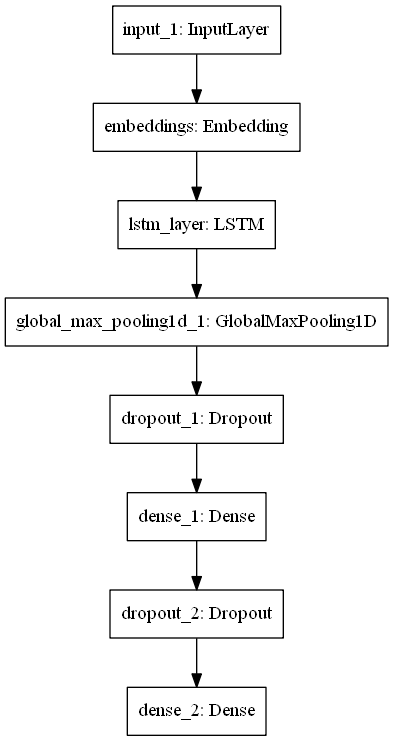

In [23]:
from keras.utils import plot_model
plot_model(model)

In [24]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 10, batch_size=64, validation_data=(x_val, y_val))

Training progress:
Train on 5552 samples, validate on 1388 samples
Epoch 1/10
5552/5552 [==============================] - 11s 2ms/step - loss: 2.3799 - accuracy: 0.1963 - auc_1: 0.7634 - precision_1: 0.0000e+00 - val_loss: 2.2254 - val_accuracy: 0.2370 - val_auc_1: 0.8063 - val_precision_1: 0.0000e+00
Epoch 2/10
5552/5552 [==============================] - 11s 2ms/step - loss: 2.2486 - accuracy: 0.2568 - auc_1: 0.7964 - precision_1: 0.0000e+00 - val_loss: 2.1322 - val_accuracy: 0.3192 - val_auc_1: 0.8272 - val_precision_1: 0.0000e+00
Epoch 3/10
5552/5552 [==============================] - 11s 2ms/step - loss: 2.1435 - accuracy: 0.3193 - auc_1: 0.8174 - precision_1: 0.6379 - val_loss: 2.0626 - val_accuracy: 0.3235 - val_auc_1: 0.8355 - val_precision_1: 0.6765
Epoch 4/10
5552/5552 [==============================] - 11s 2ms/step - loss: 2.0417 - accuracy: 0.3604 - auc_1: 0.8356 - precision_1: 0.6691 - val_loss: 1.9690 - val_accuracy: 0.3883 - val_auc_1: 0.8509 - val_precision_1: 0.6591
E

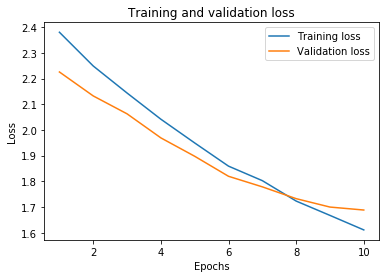

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

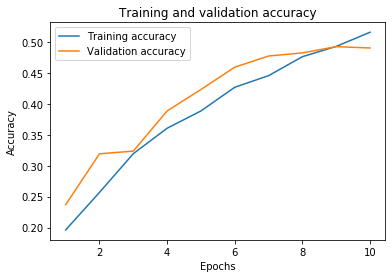

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();